# Notebook training

## Step 0 import dependencies

In [1497]:
!pip install -r requirements.txt

In [1498]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import sklearn.metrics as metrics
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.tree import DecisionTreeClassifier

## Step 1 caricamento dati

In [1499]:
path_train = './train.csv'
path_test = './test.csv'
train_data = pd.read_csv(path_train)
test_data = pd.read_csv(path_test)

## Step 2 analisi del dataset

### 2.1 Individuazione target minimo

In [1500]:
test_data['No-show'].value_counts(normalize = True)

No     0.796607
Yes    0.203393
Name: No-show, dtype: float64

Rispondendo tutti "no" si raggiunge un accuracy del 79,66% considerando lo sbilanciamento naturale del dataset, l'obiettivo minimo per creare un classificatore sensato è quindi quello di superare questo valore

### 2.2 Studio Valori Unici e Ricerca valori nulli

In [1501]:
test_data.nunique()

PatientId         15311
AppointmentID     17685
Gender                2
ScheduledDay      17461
AppointmentDay       27
Age                 102
Neighbourhood        78
Scholarship           2
Hipertension          2
Diabetes              2
Alcoholism            2
Handcap               4
SMS_received          2
No-show               2
dtype: int64

In [1502]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70736 entries, 0 to 70735
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   PatientId       70736 non-null  float64
 1   AppointmentID   70736 non-null  int64  
 2   Gender          70736 non-null  object 
 3   ScheduledDay    70736 non-null  object 
 4   AppointmentDay  70736 non-null  object 
 5   Age             70736 non-null  int64  
 6   Neighbourhood   70736 non-null  object 
 7   Scholarship     70736 non-null  int64  
 8   Hipertension    70736 non-null  int64  
 9   Diabetes        70736 non-null  int64  
 10  Alcoholism      70736 non-null  int64  
 11  Handcap         70736 non-null  int64  
 12  SMS_received    70736 non-null  int64  
 13  No-show         70736 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 7.6+ MB


Sembra che non ci siano valori nullli

In [1503]:
for col in train_data.columns:
    print(col,train_data[col].unique())

PatientId [8.14723888e+14 2.88198615e+14 6.44899846e+13 ... 6.83862113e+13
 1.56651126e+12 4.64591132e+13]
AppointmentID [5648764 5679673 5522771 ... 5623378 5751411 5696925]
Gender ['F' 'M']
ScheduledDay ['2016-05-02T16:30:07Z' '2016-05-10T10:18:20Z' '2016-03-29T15:06:50Z' ...
 '2016-04-26T13:59:09Z' '2016-05-31T10:05:14Z' '2016-05-13T14:38:50Z']
AppointmentDay ['2016-05-05T00:00:00Z' '2016-05-13T00:00:00Z' '2016-05-10T00:00:00Z'
 '2016-05-20T00:00:00Z' '2016-05-30T00:00:00Z' '2016-05-17T00:00:00Z'
 '2016-05-19T00:00:00Z' '2016-06-01T00:00:00Z' '2016-05-11T00:00:00Z'
 '2016-05-24T00:00:00Z' '2016-06-08T00:00:00Z' '2016-06-03T00:00:00Z'
 '2016-05-03T00:00:00Z' '2016-05-09T00:00:00Z' '2016-05-02T00:00:00Z'
 '2016-06-02T00:00:00Z' '2016-06-07T00:00:00Z' '2016-04-29T00:00:00Z'
 '2016-05-18T00:00:00Z' '2016-05-31T00:00:00Z' '2016-05-16T00:00:00Z'
 '2016-05-04T00:00:00Z' '2016-06-06T00:00:00Z' '2016-05-06T00:00:00Z'
 '2016-05-12T00:00:00Z' '2016-05-25T00:00:00Z' '2016-05-14T00:00:00Z']
Age 

### 2.2.1 Provo a capire se i valori Age=0 siano dei valori jolly o indichino effettivamente dei neonati

In [1504]:
print("Pazienti con 'Age' pari a 0 sono {}".format(train_data[train_data.Age == 0].shape[0]))
print("Quanti sono i pazienti con 0 di età e che hanno malattie tipiche degli adulti:")
train_data[(train_data.Age == 0) & ((train_data.Hipertension.astype(int) == 1) | (train_data.Diabetes.astype(int) == 1) | (train_data.Alcoholism.astype(int) == 1))].shape[0]

Pazienti con 'Age' pari a 0 sono 2237
Quanti sono i pazienti con 0 di età e che hanno malattie tipiche degli adulti:


0

Visto che non ce ne è nemmeno uno che abbia malattie tipiche degli adulti si può ipotizzare che siano effettivamente dei neonati.

## 2.3 Studio feature ScheduleDay e AppointmentDay

## 2.3.1 Cast a datetime di Schedule e Appointment day visti i valori che assumono 

Le date di appointmentDay sono tutte consecutive e relative all'intero mese di maggio con pochi giorni di fine aprile e di inizio giugno. ScheduledDay si sviluppa lungo un intervallo temporale di circa 8 mesi.

In [1505]:
train_data['ScheduledDay'] = pd.to_datetime(train_data['ScheduledDay']).dt.date.astype('datetime64[ns]')
test_data['ScheduledDay'] = pd.to_datetime(test_data['ScheduledDay']).dt.date.astype('datetime64[ns]')
train_data['AppointmentDay'] = pd.to_datetime(train_data['AppointmentDay']).dt.date.astype('datetime64[ns]')
test_data['AppointmentDay'] = pd.to_datetime(test_data['AppointmentDay']).dt.date.astype('datetime64[ns]')
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70736 entries, 0 to 70735
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   PatientId       70736 non-null  float64       
 1   AppointmentID   70736 non-null  int64         
 2   Gender          70736 non-null  object        
 3   ScheduledDay    70736 non-null  datetime64[ns]
 4   AppointmentDay  70736 non-null  datetime64[ns]
 5   Age             70736 non-null  int64         
 6   Neighbourhood   70736 non-null  object        
 7   Scholarship     70736 non-null  int64         
 8   Hipertension    70736 non-null  int64         
 9   Diabetes        70736 non-null  int64         
 10  Alcoholism      70736 non-null  int64         
 11  Handcap         70736 non-null  int64         
 12  SMS_received    70736 non-null  int64         
 13  No-show         70736 non-null  object        
dtypes: datetime64[ns](2), float64(1), int64(8), object(3)


Gli schedule day hanno anche l'informazione sulla data che invece è omessa negli AppointmentDay

In [1506]:
print("Valori unici in `ScheduledDay` -> {}".format(np.sort(train_data.ScheduledDay.dt.strftime('%Y-%m-%d').unique())))

Valori unici in `ScheduledDay` -> ['2015-11-10' '2015-12-03' '2015-12-07' '2015-12-08' '2015-12-14'
 '2015-12-15' '2016-01-04' '2016-01-05' '2016-01-07' '2016-01-11'
 '2016-01-13' '2016-01-14' '2016-01-20' '2016-01-21' '2016-01-22'
 '2016-01-25' '2016-01-26' '2016-01-29' '2016-02-01' '2016-02-02'
 '2016-02-03' '2016-02-04' '2016-02-05' '2016-02-11' '2016-02-12'
 '2016-02-15' '2016-02-16' '2016-02-17' '2016-02-18' '2016-02-19'
 '2016-02-22' '2016-02-23' '2016-02-24' '2016-02-25' '2016-02-26'
 '2016-02-29' '2016-03-01' '2016-03-02' '2016-03-03' '2016-03-04'
 '2016-03-05' '2016-03-07' '2016-03-08' '2016-03-09' '2016-03-10'
 '2016-03-11' '2016-03-14' '2016-03-15' '2016-03-16' '2016-03-17'
 '2016-03-18' '2016-03-19' '2016-03-21' '2016-03-22' '2016-03-23'
 '2016-03-28' '2016-03-29' '2016-03-30' '2016-03-31' '2016-04-01'
 '2016-04-05' '2016-04-06' '2016-04-07' '2016-04-08' '2016-04-09'
 '2016-04-11' '2016-04-12' '2016-04-13' '2016-04-14' '2016-04-15'
 '2016-04-16' '2016-04-18' '2016-04-19' '2

In [1507]:
print("Valori unici in `AppointmentDay` -> {}".format(np.sort(train_data.AppointmentDay.dt.strftime('%Y-%m-%d').unique())))

Valori unici in `AppointmentDay` -> ['2016-04-29' '2016-05-02' '2016-05-03' '2016-05-04' '2016-05-05'
 '2016-05-06' '2016-05-09' '2016-05-10' '2016-05-11' '2016-05-12'
 '2016-05-13' '2016-05-14' '2016-05-16' '2016-05-17' '2016-05-18'
 '2016-05-19' '2016-05-20' '2016-05-24' '2016-05-25' '2016-05-30'
 '2016-05-31' '2016-06-01' '2016-06-02' '2016-06-03' '2016-06-06'
 '2016-06-07' '2016-06-08']


### 2.3.2 Feature Engineering 'giorniAlAppuntamento'

Visto che gli scheduledDay hanno valori praticamente tutti diversi (essendo differenziati anche per l'ora) creo una nuova feature "giorniAlAppuntamento", che rappresenta la differenza tra il giorno dell'appuntamento e lil giorno della sua registrazione, sotto l'ipotesi che sicuramente appuntamenti presi lo stesso giorno o poco prima abbiano una probabilità di presentarsi sicuramente maggiore.Sarà comunque verificata l'ipotesi e rafforzata dall'analisi dei dati in seguito.

In [1508]:
giorniAlAppuntamento_train = train_data.AppointmentDay - train_data.ScheduledDay
giorniAlAppuntamento_train = giorniAlAppuntamento_train.apply(lambda x: x.total_seconds() / (3600 * 24))

giorniAlAppuntamento_test = test_data.AppointmentDay - test_data.ScheduledDay
giorniAlAppuntamento_test = giorniAlAppuntamento_test.apply(lambda x: x.total_seconds() / (3600 * 24))

train_data = pd.concat([train_data, giorniAlAppuntamento_train], axis = 1)
test_data = pd.concat([test_data, giorniAlAppuntamento_test], axis = 1)

train_data.rename(inplace = True, mapper = {0: 'giorniAlAppuntamento'},axis = 1)
test_data.rename(inplace = True, mapper = {0: 'giorniAlAppuntamento'},axis = 1)

train_data = train_data.drop(['ScheduledDay'], axis = 1, inplace = False)
test_data = test_data.drop(['ScheduledDay'], axis = 1, inplace = False)

train_data = train_data.drop(['AppointmentDay'], axis = 1, inplace = False)
test_data = test_data.drop(['AppointmentDay'], axis = 1, inplace = False)

In [1509]:
train_data.giorniAlAppuntamento.unique()

array([  3.,  42.,   0.,  17.,  46.,  22.,  33.,   2.,  25.,  23.,   4.,
        18.,  10.,   6.,   9.,  64.,   1.,  13.,  14.,  30.,  27.,   7.,
        11.,  63.,  85.,  65.,  28.,  36.,  38.,   5.,   8.,  31.,  16.,
        12.,  43.,  32.,  29.,  26.,  24.,  15.,  21.,  19.,  34.,  45.,
        72.,  37.,  67.,  40.,  20.,  35.,  69.,  61.,  49.,  84.,  58.,
        41.,  53.,  44.,  50., 162.,  59.,  52.,  39., 142.,  79.,  90.,
        54.,  91.,  74.,  48., 111.,  60.,  66.,  76.,  62.,  70.,  56.,
        55.,  51.,  75.,  83.,  57.,  47.,  95.,  71.,  88.,  68., 109.,
       176.,  77., 108.,  78.,  80., 133., 126.,  73., 169., 112.,  98.,
       155.,  -1.,  82.,  87., 119., 104.,  86.,  89., 122.,  81., 103.,
       179.,  92., 115.,  93., 151.,  96., 132.,  -6., 110., 107., 105.,
       101., 146.,  94., 102., 125.])

In [1510]:
train_data.drop(train_data[train_data.giorniAlAppuntamento < 0].index, inplace = True)
test_data.drop(test_data[test_data.giorniAlAppuntamento < 0].index, inplace = True)

### 2.3.3 Studio andamento della feature appena creata

In [1511]:
def probNoShow(dataset, group_by):
    df = pd.crosstab(index = dataset[group_by], columns = dataset['No-show']).reset_index()
    df['probNoShow'] = df['No'] / (df['No'] + df['Yes'])
    return df[[group_by, 'probNoShow']]

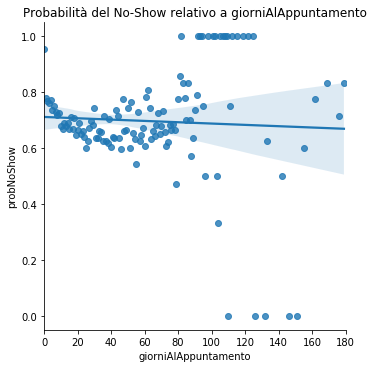

In [1512]:
sns.lmplot(data = probNoShow(train_data, 'giorniAlAppuntamento'), x = 'giorniAlAppuntamento', 
           y = 'probNoShow', fit_reg = True)
plt.xlim(0, 180)
plt.title('Probabilità del No-Show relativo a giorniAlAppuntamento')
plt.show()

Come sospettato la feature creata risulta essere significativa sopratutto per una differenza molto bassa o prossima allo 0. Si registra anche un aumento di nuovo della probabilità di show dopo attese molto lunghe (superiori agli 80 giorni)

### 2.3.4 Trasformazione della feature in categorica (suddivisione in fasce)

In [1513]:
def appointment_div_cat(dataset) :
    if dataset['giorniAlAppuntamento'] <= 0 :
        return "StessoGiorno"
    elif (dataset['giorniAlAppuntamento'] > 0) & (dataset['giorniAlAppuntamento'] <= 5 ):
        return "Pochi giorni dopo"
    elif (dataset['giorniAlAppuntamento'] > 5) & (dataset['giorniAlAppuntamento'] <= 80) :
        return "Fino a 3 mesi dopo"
    elif (dataset['giorniAlAppuntamento'] > 80):
        return "Dopo 3 mesi"
train_data['giorniAlAppuntamentoCategorical'] = train_data.apply(lambda dataset:appointment_div_cat(dataset),axis = 1)
test_data['giorniAlAppuntamentoCategorical'] = test_data.apply(lambda dataset:appointment_div_cat(dataset),axis = 1)
# Colonne vecchie ormai non più utili
train_data = train_data.drop(columns=['giorniAlAppuntamento'])
test_data = test_data.drop(columns=['giorniAlAppuntamento'])

In [1514]:
train_data['giorniAlAppuntamentoCategorical'].nunique()

4

Dopo numerose prove la suddivisione in fasce della feature (rispecchiando gli andamenti) è risultata migliore rispetto all'utilizzo della feature come valore numerico continuo.

### 2.4 Drop degli identificatori 

In [1515]:
train_data.drop(['AppointmentID','PatientId'], axis = 1, inplace = True)
test_data.drop(['AppointmentID','PatientId'], axis = 1, inplace = True)

Drop degli identificatori in quanto non significativi

### 2.5 Studio dell'andamento di Age

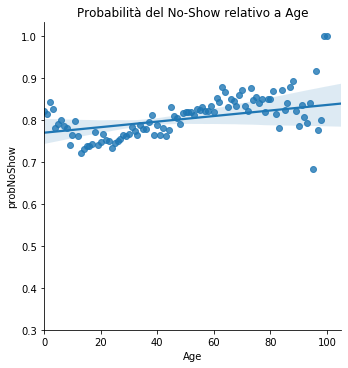

In [1516]:
sns.lmplot(data = probNoShow(train_data, 'Age'), x = 'Age', y = 'probNoShow', fit_reg = True)
plt.xlim(0, 105)
plt.title('Probabilità del No-Show relativo a Age')
plt.show()

Come ci si poteva aspettare, vista l'attenzione che si dedica ai bambini, ad età molto basse (<8) la probabilità del noShow scende drasticamente. Scende invece per l'età adolescenziale e i giovani adulti per poi risalire nelle persone anziane. Sembra quindi essere una feature significativa probabilmente ancor di più se distinta in fasce di età distinguendo le fasce dei bambini e degli anziani dal resto (le categorie con lo show più alto).

### 2.5.1 Trasformazione di Age in categorica a fasce

In [1517]:
def age_div_cat(dataset) :
    if dataset['Age'] <= 0 :
        return "Neonati"
    if (dataset['Age'] > 0) & (dataset['Age'] <= 5) :
        return "Bambini"
    elif (dataset['Age'] > 5) & (dataset['Age'] <= 11 ):
        return "Giovani"
    elif (dataset['Age'] > 11) & (dataset['Age'] <= 65) :
        return "Adulti"
    elif (dataset['Age'] > 65):
        return "Anziani"
train_data['AgeCategorical'] = train_data.apply(lambda dataset:age_div_cat(dataset),axis = 1)
test_data['AgeCategorical'] = test_data.apply(lambda dataset:age_div_cat(dataset),axis = 1)
# Colonne vecchie ormai non più utili
train_data = train_data.drop(columns=['Age'])
test_data = test_data.drop(columns=['Age'])

Come per la feature precedente anche per questa dopo numerose prove è risultato migliore trasformala in una categorica invece di mantenere un valore numerico continuo.

In [1518]:
# Colonne categoriche
object_cols = [col for col in train_data.columns if train_data[col].dtype == "object" or train_data[col].dtype == "datetime64[ns]"]

numerical_cols = [col for col in train_data.columns if train_data[col].dtype == 'int64' 
                                                          or train_data[col].dtype == 'float64']
good_label_cols = [col for col in object_cols if set(train_data[col]) == set(test_data[col])]

bad_label_cols = list(set(test_data.columns)-set(good_label_cols)-set(numerical_cols))

object_nunique = list(map(lambda col: train_data[col].nunique(), object_cols))
d = dict(zip(object_cols, object_nunique))

print('Number of unique entries by column, in ascending order:')
sorted(d.items(), key=lambda x: x[1])

Number of unique entries by column, in ascending order:


[('Gender', 2),
 ('No-show', 2),
 ('giorniAlAppuntamentoCategorical', 4),
 ('AgeCategorical', 5),
 ('Neighbourhood', 81)]

### 2.6 Studio della feature Neighbourhood

Provando vari modelli in diverse situazioni la Neighbourhood non è mai risultata incidente, anzi il più delle volte era dannosa. E' stata droppata per questo motivo.

## Parte di analisi che non sono riuscito a terminare

### 2.7 Studio delle feature Diabetes, Hipertension, Handcap e Alcoholism

### 2.8 Studio di SMS_received

### 2.9 Studio di Scholarship

## 3 Suddivisione in X_train, y_train, X_test, y_test

In [1519]:
y_train = train_data['No-show']
X_train = train_data.drop(['No-show','Neighbourhood','Diabetes'], axis = 1, inplace = False)
y_test = test_data['No-show']
X_test = test_data.drop(['No-show','Neighbourhood','Diabetes'], axis = 1, inplace = False)

X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70733 entries, 0 to 70735
Data columns (total 8 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   Gender                           70733 non-null  object
 1   Scholarship                      70733 non-null  int64 
 2   Hipertension                     70733 non-null  int64 
 3   Alcoholism                       70733 non-null  int64 
 4   Handcap                          70733 non-null  int64 
 5   SMS_received                     70733 non-null  int64 
 6   giorniAlAppuntamentoCategorical  70733 non-null  object
 7   AgeCategorical                   70733 non-null  object
dtypes: int64(5), object(3)
memory usage: 4.9+ MB


In [1520]:
X_train.nunique()

Gender                             2
Scholarship                        2
Hipertension                       2
Alcoholism                         2
Handcap                            5
SMS_received                       2
giorniAlAppuntamentoCategorical    4
AgeCategorical                     5
dtype: int64

## 4 Encoding

In [1521]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17685 entries, 0 to 17684
Data columns (total 8 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   Gender                           17685 non-null  object
 1   Scholarship                      17685 non-null  int64 
 2   Hipertension                     17685 non-null  int64 
 3   Alcoholism                       17685 non-null  int64 
 4   Handcap                          17685 non-null  int64 
 5   SMS_received                     17685 non-null  int64 
 6   giorniAlAppuntamentoCategorical  17685 non-null  object
 7   AgeCategorical                   17685 non-null  object
dtypes: int64(5), object(3)
memory usage: 1.2+ MB


In [1522]:
label_encoder = LabelEncoder()
label_X_train = X_train
label_X_test = X_test
categorical_cols = set(['Gender','giorniAlAppuntamentoCategorical','AgeCategorical'])
for col in categorical_cols:
    label_X_train[col] = label_encoder.fit_transform(label_X_train[col])
    for ind in X_test[col].index:
        if not X_test[col][ind] in label_encoder.classes_:
            X_test[col][ind] = 'other'
    label_encoder.classes_ = np.append(label_encoder.classes_,'other')    
    label_X_test[col] = label_encoder.transform(label_X_test[col])
label_X_train.nunique()

Gender                             2
Scholarship                        2
Hipertension                       2
Alcoholism                         2
Handcap                            5
SMS_received                       2
giorniAlAppuntamentoCategorical    4
AgeCategorical                     5
dtype: int64

Ho messo un controllo sui valori categorici encoded in modo che se dovessero apparire "unseen label" non viene lanciato un errore ma semplicemente vengono sostituiti con "other" e gli viene messa una label corrispondente a quel gruppo. Non penso sia necessario ma male non fa.

## 5 Scelta del Modello

In [1523]:
rf = RandomForestClassifier(random_state = 1)
rf.fit(label_X_train, y_train)
predictions_rf = rf.predict(label_X_test)

dt = DecisionTreeClassifier(random_state = 1)
dt.fit(label_X_train, y_train)
predictions_dt = dt.predict(label_X_test)

lr = LogisticRegression(max_iter = 200)
lr.fit(label_X_train, y_train)
predictions_lr = lr.predict(label_X_test)

knn = KNeighborsClassifier(n_neighbors = 18, n_jobs = -1)
knn.fit(label_X_train, y_train)
predictions_knn = knn.predict(label_X_test)

In [1524]:
validation_accuracy_rf = []
   
validation_accuracy_rf.append(rf.score(label_X_test, y_test))

print('Validation accuracy random forest: ', validation_accuracy_rf)

validation_accuracy_dt = []
   
validation_accuracy_dt.append(dt.score(label_X_test, y_test))

print('Validation accuracy decision tree: ', validation_accuracy_dt)

validation_accuracy_lr = []
   
validation_accuracy_lr.append(lr.score(label_X_test, y_test))

print('Validation accuracy logistic regression: ', validation_accuracy_lr)

validation_accuracy_knn = []
   
validation_accuracy_knn.append(knn.score(label_X_test, y_test))

print('Validation accuracy KNN: ', validation_accuracy_knn)

Validation accuracy random forest:  [0.7968334746960701]
Validation accuracy decision tree:  [0.7970596550749223]
Validation accuracy logistic regression:  [0.7947413061916879]
Validation accuracy KNN:  [0.7970031099802092]


In [1525]:
n_neighbors = range(10,25)
for n_neighbor in n_neighbors:
    model = KNeighborsClassifier(n_neighbors = n_neighbor,n_jobs = -1)
    model.fit(label_X_train, y_train)
    score = model.score(label_X_test, y_test)
    print('With neighbor: ', n_neighbor, 'score: ', score)

With neighbor:  10 score:  0.7944585807181227
With neighbor:  11 score:  0.7880689850155499
With neighbor:  12 score:  0.7962114786542267
With neighbor:  13 score:  0.7852417302798982
With neighbor:  14 score:  0.7857506361323155
With neighbor:  15 score:  0.7854679106587503
With neighbor:  16 score:  0.7968900197907831
With neighbor:  17 score:  0.7964376590330788
With neighbor:  18 score:  0.7970031099802092
With neighbor:  19 score:  0.7968900197907831
With neighbor:  20 score:  0.7970031099802092
With neighbor:  21 score:  0.7968900197907831
With neighbor:  22 score:  0.7970031099802092
With neighbor:  23 score:  0.7969465648854962
With neighbor:  24 score:  0.7970031099802092


In [1526]:
n_features = len(label_X_train.columns)
max_features = np.sqrt(n_features)
max_features

2.8284271247461903

In [1527]:
max_features = [2,3,4]

for max_feature in max_features:
    model = RandomForestClassifier(random_state = 1, max_features = max_feature)
    model.fit(label_X_train, y_train)
    score = model.score(label_X_test, y_test)
    print('With depth: ', max_feature, 'score: ', score)

With depth:  2 score:  0.7968334746960701
With depth:  3 score:  0.7968900197907831
With depth:  4 score:  0.7968900197907831


In [1528]:
estimators = [50,100,150,200,230,250]

for estimator in estimators:
    model = RandomForestClassifier(random_state = 1, max_features = 2, n_estimators = estimator)
    model.fit(label_X_train, y_train)
    score = model.score(label_X_test, y_test)
    print('With estimator: ', estimator, 'score: ', score)

With estimator:  50 score:  0.7968334746960701
With estimator:  100 score:  0.7968334746960701
With estimator:  150 score:  0.7968900197907831
With estimator:  200 score:  0.7968900197907831
With estimator:  230 score:  0.7969465648854962
With estimator:  250 score:  0.7969465648854962


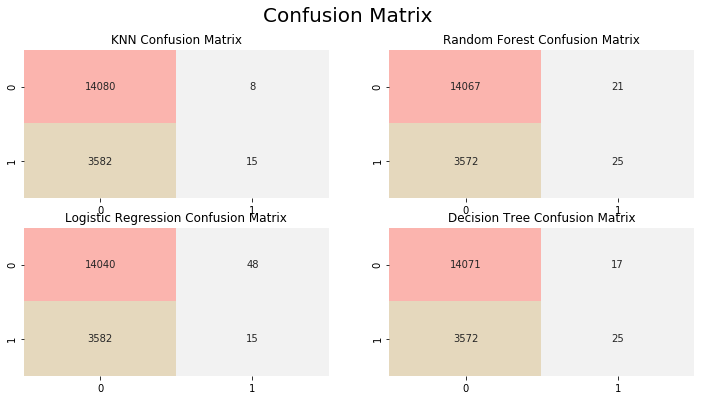

In [1529]:
confusion_matrix= metrics.confusion_matrix(y_test, predictions_knn)

plt.figure(figsize=(12,6))

plt.suptitle("Confusion Matrix",fontsize=20)

plt.subplot(2,2,1)
plt.title("KNN Confusion Matrix")
sns.heatmap(confusion_matrix, cbar=False,annot=True,cmap="Pastel1_r",fmt="d")

confusion_matrix= metrics.confusion_matrix(y_test, predictions_rf)

plt.subplot(2,2,2)
plt.title("Random Forest Confusion Matrix")
sns.heatmap(confusion_matrix, cbar=False,annot=True,cmap="Pastel1_r",fmt="d")

confusion_matrix= metrics.confusion_matrix(y_test, predictions_lr)

plt.subplot(2,2,3)
plt.title("Logistic Regression Confusion Matrix")
sns.heatmap(confusion_matrix, cbar=False,annot=True,cmap="Pastel1_r",fmt="d")

confusion_matrix= metrics.confusion_matrix(y_test, predictions_dt)
plt.subplot(2,2,4)
plt.title("Decision Tree Confusion Matrix")
sns.heatmap(confusion_matrix, cbar=False,annot=True,cmap="Pastel1_r",fmt="d")

plt.show()

## 5.1 Commenti

Il dataset non si è rivelato per nulla semplice. Non sono riuscito a trovare una significativa correlazione tra le features. Ho provato ad usarle tutte inizialmente prima di fare le modifiche (droppando solo gli ID) ma nessun modello riusciva ad avere un'accuracy elevata (a parte la logistic regression che rispondeva sempre no al problema). Dopo numerosi tentativi di feature engineering e tweaking dei parametri dei modelli sono riuscito a raggiungere un risultato che per lo meno performa meglio del rispondere semplicemente "no" (seppur veramente in maniera irrisoria) sia con i DecisionTree che con il KNN. Visti i migliori risultati costanti in tutte le prove ho scelto il DecisionTree come modello finale anche se sono ben consapevole che un modello che ha un accuracy sul validation quasi identica alla distribuzione del target con la frequenza del valore più alto è praticamente inutile (continua a predire per la maggior parte delle volte "no"). Spero che posssa comunque apprezzare i miei sforzi, sinceramente non so che altro fare per migliorare. Ho provato tutto questo per evitare di consegnare una semplice regressione logistica che rispondesse sempre e solo "no".

## 6 Scelta del modello finale e stampa dell'Accuracy

### 6.1 DecisionTreeClassifier

In [1536]:
dt = DecisionTreeClassifier(random_state = 1)
dt.fit(label_X_train, y_train)
predictions_final = dt.predict(label_X_test)

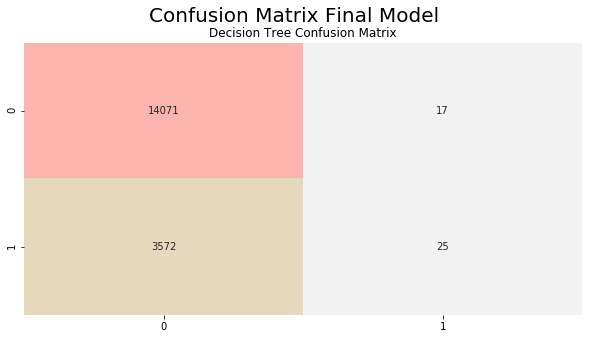

In [1537]:
confusion_matrix= metrics.confusion_matrix(y_test, predictions_final)

plt.figure(figsize=(10,5))

plt.suptitle("Confusion Matrix Final Model",fontsize=20)

plt.subplot(1,1,1)
plt.title("Decision Tree Confusion Matrix")
sns.heatmap(confusion_matrix, cbar=False,annot=True,cmap="Pastel1_r",fmt="d")
plt.show()

### 6.2 Accuracy

In [1539]:
validation_accuracy_dt = []
   
validation_accuracy_dt.append(dt.score(label_X_test, y_test))

print('Accuracy modello finale: ', validation_accuracy_dt)

Accuracy modello finale:  [0.7970596550749223]
